# Feature Engineering

In [46]:
# Importar las librerías necesarias para el análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import warnings
from sklearn.preprocessing import MinMaxScaler

# Ignorar advertencias (warnings) para mantener una salida limpia
warnings.filterwarnings("ignore")

# Cargar el dataframe limpio.
df_cleaned = pd.read_csv('datos/df_cleaned.csv')

# Haremos una copia para mantener el original intacto.
df_featured = df_cleaned.copy()

df_featured.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


### Sección 1: Transformación Logarítmica de Variables Numéricas

#### Justificación
El EDA indicó que muchas de las mediciones numéricas (concentraciones de químicos, etc.) presentan una distribución fuertemente sesgada a la derecha. Para algoritmos basados en distancia como K-Means, este sesgo puede impactar negativamente el rendimiento. Aplicar una transformación logarítmica ayuda a normalizar estas distribuciones, haciéndolas más simétricas y reduciendo el efecto de los valores atípicos extremos.

#### Metodología
1.  **Identificar Columnas:** Se seleccionarán todas las columnas de mediciones numéricas originales (las que terminan en `mg/L`, `mS/cm`, etc.).
2.  **Aplicar Transformación `log1p`:** Se utilizará la función `np.log1p`, que calcula `log(1 + x)`. Esta función es preferible a `np.log` porque maneja adecuadamente los valores de cero, que están presentes en el dataset.
3.  **Crear Nuevas Columnas:** Los resultados se almacenarán en nuevas columnas con el sufijo `_log` para mantener las mediciones originales y las transformadas para futuras referencias.

Se aplicará la transformación logarítmica a 14 columnas.
  - Columna 'ALC_mg/L' transformada a 'ALC_mg/L_log'.
  - Columna 'CONDUCT_mS/cm' transformada a 'CONDUCT_mS/cm_log'.
  - Columna 'SDT_M_mg/L' transformada a 'SDT_M_mg/L_log'.
  - Columna 'FLUORUROS_mg/L' transformada a 'FLUORUROS_mg/L_log'.
  - Columna 'DUR_mg/L' transformada a 'DUR_mg/L_log'.
  - Columna 'COLI_FEC_NMP/100_mL' transformada a 'COLI_FEC_NMP/100_mL_log'.
  - Columna 'N_NO3_mg/L' transformada a 'N_NO3_mg/L_log'.
  - Columna 'AS_TOT_mg/L' transformada a 'AS_TOT_mg/L_log'.
  - Columna 'CD_TOT_mg/L' transformada a 'CD_TOT_mg/L_log'.
  - Columna 'CR_TOT_mg/L' transformada a 'CR_TOT_mg/L_log'.
  - Columna 'HG_TOT_mg/L' transformada a 'HG_TOT_mg/L_log'.
  - Columna 'PB_TOT_mg/L' transformada a 'PB_TOT_mg/L_log'.
  - Columna 'MN_TOT_mg/L' transformada a 'MN_TOT_mg/L_log'.
  - Columna 'FE_TOT_mg/L' transformada a 'FE_TOT_mg/L_log'.


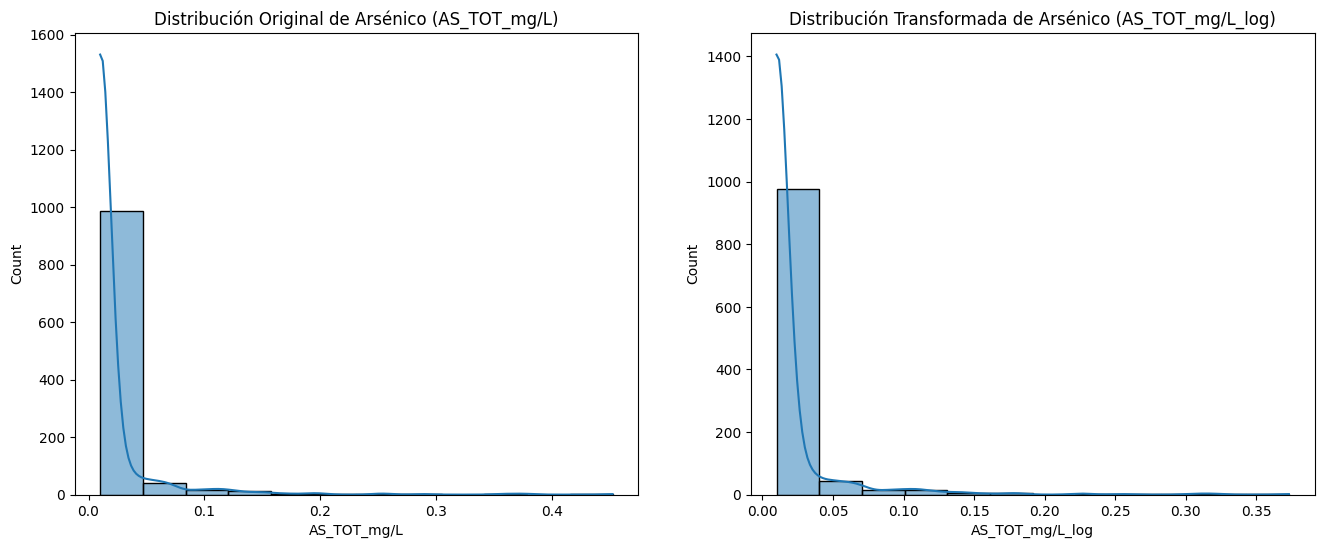

In [47]:
# 1. Identificar las columnas numéricas de mediciones originales
numerical_measurement_cols = [
    'ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L',
    'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L', 'CD_TOT_mg/L',
    'CR_TOT_mg/L', 'HG_TOT_mg/L', 'PB_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L'
]

print(f"Se aplicará la transformación logarítmica a {len(numerical_measurement_cols)} columnas.")

# 2. Aplicar la transformación log1p y crear nuevas columnas
for col in numerical_measurement_cols:
    log_col_name = f"{col}_log"
    df_featured[log_col_name] = np.log1p(df_featured[col])
    print(f"  - Columna '{col}' transformada a '{log_col_name}'.")

# 3. Visualizar el antes y el después para una columna como ejemplo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df_featured['AS_TOT_mg/L'], kde=True, ax=axes[0])
axes[0].set_title('Distribución Original de Arsénico (AS_TOT_mg/L)')

sns.histplot(df_featured['AS_TOT_mg/L_log'], kde=True, ax=axes[1])
axes[1].set_title('Distribución Transformada de Arsénico (AS_TOT_mg/L_log)')
plt.show()

### Sección 2: Creación de un Índice de Salinidad (`salinity_index`)

#### Justificación
El Análisis Exploratorio de Datos (EDA) reveló una alta correlación entre las variables que miden la mineralización del agua: `CONDUCT_mS/cm` (Conductividad), `SDT_M_mg/L` (Sólidos Disueltos Totales) y `DUR_mg/L` (Dureza). Para reducir la multicolinealidad y consolidar esta información en una única y robusta característica, crearemos un `salinity_index`.

#### Metodología
1.  **Seleccionar Variables:** Se aislarán las tres columnas mencionadas.
2.  **Escalar:** Se aplicará `MinMaxScaler` para normalizar cada variable a un rango de 0 a 1. Esto es crucial para que ninguna variable domine a las otras debido a su escala original.
3.  **Combinar:** El índice se calculará como el promedio de los tres valores escalados para cada muestra. El resultado será una nueva columna, `salinity_index`, que representa el nivel general de salinidad/mineralización.

In [48]:
# 1. Seleccionar las columnas relacionadas con la salinidad
salinity_features = ['CONDUCT_mS/cm', 'SDT_M_mg/L', 'DUR_mg/L']

# 2. Inicializar el escalador y transformar los datos
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_featured[salinity_features])

# Convertir el resultado a un DataFrame para facilitar el cálculo
df_scaled = pd.DataFrame(scaled_features, columns=salinity_features, index=df_featured.index)

# 3. Calcular el promedio de las características escaladas y asignarlo a la nueva columna
df_featured['salinity_index'] = df_scaled.mean(axis=1)

print("Se ha creado la característica 'salinity_index'.")
df_featured[['CONDUCT_mS/cm', 'SDT_M_mg/L', 'DUR_mg/L', 'salinity_index']].head()

Se ha creado la característica 'salinity_index'.


,CONDUCT_mS/cm,SDT_M_mg/L,DUR_mg/L,salinity_index
0,940.0,603.6,213.7320,0.035389
1,608.0,445.4,185.0514,0.026252
2,532.0,342.0,120.7190,0.018808
3,686.0,478.6,199.8790,0.029094
4,1841.0,1179.0,476.9872,0.077085


### Sección 3: One-Hot Encoding de la Variable `SEMAFORO`

#### Justificación
La columna `SEMAFORO` es una variable categórica nominal que resume la calidad general del agua. Los algoritmos de clustering como K-Means no pueden procesar datos de texto directamente. El One-Hot Encoding es la técnica adecuada para convertir estas categorías en un formato numérico que el modelo pueda utilizar, sin introducir un orden artificial entre ellas.

#### Metodología
Se utilizará la función `pd.get_dummies` de pandas para crear nuevas columnas binarias (0 o 1) para cada categoría presente en la columna `SEMAFORO`. Se añadirá un prefijo para mayor claridad.

In [49]:
# Aplicar One-Hot Encoding a la columna 'SEMAFORO'
semaforo_dummies = pd.get_dummies(df_featured['SEMAFORO'], prefix='SEMAFORO')

# Unir las nuevas columnas al DataFrame principal
df_featured = pd.concat([df_featured, semaforo_dummies], axis=1)

print("Se han creado las características One-Hot para 'SEMAFORO'.")
df_featured[['SEMAFORO', 'SEMAFORO_Amarillo', 'SEMAFORO_Rojo', 'SEMAFORO_Verde']].head()

Se han creado las características One-Hot para 'SEMAFORO'.


,SEMAFORO,SEMAFORO_Amarillo,SEMAFORO_Rojo,SEMAFORO_Verde
0,Verde,False,False,True
1,Verde,False,False,True
2,Rojo,False,True,False
3,Verde,False,False,True
4,Rojo,False,True,False


### Sección 4: Creación de un Contador de Contaminantes (`contaminant_count`)

#### Justificación
La columna `CONTAMINANTES` es un campo de texto que puede contener múltiples valores (ej. "AS, FE"). El número de contaminantes presentes en una muestra es una característica cuantitativa valiosa por sí misma, ya que indica la complejidad de la contaminación. Crear una característica numérica a partir de esta información la hace directamente utilizable por el modelo.

#### Metodología
Se aplicará una función a la columna `CONTAMINANTES`. Para cada fila:
1.  Si el valor es "Sin Contaminantes", el conteo será 0.
2.  De lo contrario, se contará el número de elementos separados por comas y se sumará 1 (ya que `n` comas separan `n+1` elementos).

In [50]:
# Definir la función para contar contaminantes
def count_contaminants(contaminant_string):
    if contaminant_string == 'Sin Contaminantes':
        return 0
    else:
        # Contar el número de comas y sumar 1 para obtener el número de contaminantes
        return contaminant_string.count(',') + 1

# Aplicar la función para crear la nueva columna
df_featured['contaminant_count'] = df_featured['CONTAMINANTES'].apply(count_contaminants)

print("Se ha creado la característica 'contaminant_count'.")
df_featured[['CONTAMINANTES', 'contaminant_count']].head(10)

Se ha creado la característica 'contaminant_count'.


,CONTAMINANTES,contaminant_count
0,Sin Contaminantes,0
1,Sin Contaminantes,0
2,"FLUO,AS,",3
3,Sin Contaminantes,0
4,"NO3,",2
5,"CF,",2
6,Sin Contaminantes,0
7,"CONDUC,NO3,",3
8,Sin Contaminantes,0
9,"DT,CF,AS,MN,FE,",6


### Sección 5: Discretización y Codificación Ordinal de Variables de Calidad

#### Justificación
El dataset ya contiene variables discretizadas (binned) en las columnas `CALIDAD_*`, las cuales fueron creadas a partir de reglas de negocio y estándares de calidad. Estas categorías (ej. 'Potable - Excelente', 'Buena calidad') son ordinales, es decir, tienen un orden intrínseco. Para que el modelo de clustering pueda utilizar esta información, debemos convertir estas etiquetas de texto en valores numéricos que preserven dicho orden.

#### Metodología
1.  **Identificar Columnas:** Se seleccionarán todas las columnas que comiencen con `CALIDAD_`.
2.  **Definir Mapeo Ordinal:** Se creará un diccionario que asigne un valor numérico a cada etiqueta de calidad, donde valores más bajos representen mejor calidad y valores más altos peor calidad.
3.  **Aplicar Codificación:** Se iterará sobre las columnas de calidad y se aplicará el mapeo para crear nuevas columnas numéricas con el sufijo `_encoded`. Esto transforma las categorías en características ordinales numéricas, listas para el modelado.

In [51]:
# 1. Identificar las columnas de calidad
quality_cols = [col for col in df_featured.columns if col.startswith('CALIDAD_')]

# 2. Definir el mapeo ordinal. Valores más bajos son de mejor calidad.
ordinal_mapping = {
    # Calidad General
    'Potable - Excelente': 0,
    'Buena calidad': 1,
    'Aceptable': 2,
    'Mala calidad': 3,
    'Fuertemente contaminada': 4,
    'Contaminada': 4, # Unificar con 'Fuertemente contaminada'

    # Riego (SDT_ra)
    'Clase I: Excelente': 0,
    'Clase II: Buena': 1,
    'Clase III: Permisible': 2,
    'Clase IV: Dudosa': 3,
    'Clase V: No recomendable': 4,

    # FAAP (Fuente Alterna de Abastecimiento Público)
    'Apta como FAAP': 1, # Se considera buena pero no excelente
    'No apta como FAAP': 4,

    # Dureza
    'Agua suave': 0,
    'Agua ligeramente dura': 1,
    'Agua dura': 2,
    'Agua muy dura': 3,

    # Salinidad
    'Agua dulce': 0,
    'Agua ligeramente salobre': 1,
    'Agua moderadamente salobre': 2,
    'Agua muy salobre': 3
}

print(f"Se aplicará codificación ordinal a {len(quality_cols)} columnas:")

# 3. Aplicar el mapeo
for col in quality_cols:
    encoded_col_name = f"{col}_encoded"
    df_featured[encoded_col_name] = df_featured[col].map(ordinal_mapping)
    print(f"  - Columna '{col}' codificada como '{encoded_col_name}'.")

# Mostrar un ejemplo para verificar la codificación
print("\n--- Ejemplo de Codificación Ordinal para 'CALIDAD_AS' ---")
df_featured[['CALIDAD_AS', 'CALIDAD_AS_encoded']].head(10).drop_duplicates()

Se aplicará codificación ordinal a 15 columnas:
  - Columna 'CALIDAD_ALC' codificada como 'CALIDAD_ALC_encoded'.
  - Columna 'CALIDAD_CONDUC' codificada como 'CALIDAD_CONDUC_encoded'.
  - Columna 'CALIDAD_SDT_ra' codificada como 'CALIDAD_SDT_ra_encoded'.
  - Columna 'CALIDAD_SDT_salin' codificada como 'CALIDAD_SDT_salin_encoded'.
  - Columna 'CALIDAD_FLUO' codificada como 'CALIDAD_FLUO_encoded'.
  - Columna 'CALIDAD_DUR' codificada como 'CALIDAD_DUR_encoded'.
  - Columna 'CALIDAD_COLI_FEC' codificada como 'CALIDAD_COLI_FEC_encoded'.
  - Columna 'CALIDAD_N_NO3' codificada como 'CALIDAD_N_NO3_encoded'.
  - Columna 'CALIDAD_AS' codificada como 'CALIDAD_AS_encoded'.
  - Columna 'CALIDAD_CD' codificada como 'CALIDAD_CD_encoded'.
  - Columna 'CALIDAD_CR' codificada como 'CALIDAD_CR_encoded'.
  - Columna 'CALIDAD_HG' codificada como 'CALIDAD_HG_encoded'.
  - Columna 'CALIDAD_PB' codificada como 'CALIDAD_PB_encoded'.
  - Columna 'CALIDAD_MN' codificada como 'CALIDAD_MN_encoded'.
  - Columna 'C

,CALIDAD_AS,CALIDAD_AS_encoded
0,Apta como FAAP,1
2,No apta como FAAP,4
4,Potable - Excelente,0


### Sección 6: Codificación de Variables Categóricas Restantes

#### Justificación
Para completar la preparación de los datos para el modelado, es necesario codificar las variables categóricas restantes que son relevantes y tienen baja cardinalidad. Específicamente, `SUBTIPO` (nominal) y las columnas `CUMPLE_CON_*` (binarias).

#### Metodología
1.  **One-Hot Encoding para `SUBTIPO`:** Se utilizará `pd.get_dummies` para convertir la columna `SUBTIPO` en múltiples columnas binarias, una para cada tipo de sitio. Esto es apropiado ya que no hay un orden inherente entre los tipos.
2.  **Binary Encoding para `CUMPLE_CON_*`:** Las columnas de cumplimiento, que contienen 'SI' y 'NO', se transformarán a un formato numérico (1 y 0) mediante un mapeo simple. Esto las convierte en características binarias listas para el análisis.

In [52]:
# 1. One-Hot Encoding para la columna 'SUBTIPO'
subtipo_dummies = pd.get_dummies(df_featured['SUBTIPO'], prefix='SUBTIPO')
df_featured = pd.concat([df_featured, subtipo_dummies], axis=1)
print("Se han creado las características One-Hot para 'SUBTIPO'.")

# 2. Binary Encoding para las columnas 'CUMPLE_CON_*'
compliance_cols = [col for col in df_featured.columns if col.startswith('CUMPLE_CON_')]
compliance_mapping = {'SI': 1, 'NO': 0}

print(f"\nSe aplicará codificación binaria a {len(compliance_cols)} columnas de cumplimiento:")
for col in compliance_cols:
    encoded_col_name = f"{col}_encoded"
    df_featured[encoded_col_name] = df_featured[col].map(compliance_mapping)
    print(f"  - Columna '{col}' codificada como '{encoded_col_name}'.")

# Mostrar un ejemplo para verificar la codificación
print("\n--- Ejemplo de Codificación para 'CUMPLE_CON_AS' ---")
df_featured[['CUMPLE_CON_AS', 'CUMPLE_CON_AS_encoded']].head()

Se han creado las características One-Hot para 'SUBTIPO'.

Se aplicará codificación binaria a 15 columnas de cumplimiento:
  - Columna 'CUMPLE_CON_ALC' codificada como 'CUMPLE_CON_ALC_encoded'.
  - Columna 'CUMPLE_CON_COND' codificada como 'CUMPLE_CON_COND_encoded'.
  - Columna 'CUMPLE_CON_SDT_ra' codificada como 'CUMPLE_CON_SDT_ra_encoded'.
  - Columna 'CUMPLE_CON_SDT_salin' codificada como 'CUMPLE_CON_SDT_salin_encoded'.
  - Columna 'CUMPLE_CON_FLUO' codificada como 'CUMPLE_CON_FLUO_encoded'.
  - Columna 'CUMPLE_CON_DUR' codificada como 'CUMPLE_CON_DUR_encoded'.
  - Columna 'CUMPLE_CON_CF' codificada como 'CUMPLE_CON_CF_encoded'.
  - Columna 'CUMPLE_CON_NO3' codificada como 'CUMPLE_CON_NO3_encoded'.
  - Columna 'CUMPLE_CON_AS' codificada como 'CUMPLE_CON_AS_encoded'.
  - Columna 'CUMPLE_CON_CD' codificada como 'CUMPLE_CON_CD_encoded'.
  - Columna 'CUMPLE_CON_CR' codificada como 'CUMPLE_CON_CR_encoded'.
  - Columna 'CUMPLE_CON_HG' codificada como 'CUMPLE_CON_HG_encoded'.
  - Columna '

,CUMPLE_CON_AS,CUMPLE_CON_AS_encoded
0,SI,1
1,SI,1
2,NO,0
3,SI,1
4,SI,1


### Sección 7: Guardar el DataFrame con las Nuevas Características

Finalmente, el DataFrame resultante, que ahora incluye todas las características diseñadas y codificadas, se guarda en un nuevo archivo CSV para ser utilizado en la siguiente etapa del pipeline: el modelado.

In [53]:
# Guardar el dataframe con las nuevas características en un nuevo archivo
output_path = 'datos/df_featured.csv'
df_featured.to_csv(output_path, index=False)

print(f"El DataFrame con las nuevas características se ha guardado en: {output_path}")

El DataFrame con las nuevas características se ha guardado en: datos/df_featured.csv
